# MathGPT

Let us build a Maths Small Language Model (SLM) from scratch.
Our goal is to generate creative and coherent output as per the input arithmetic question.

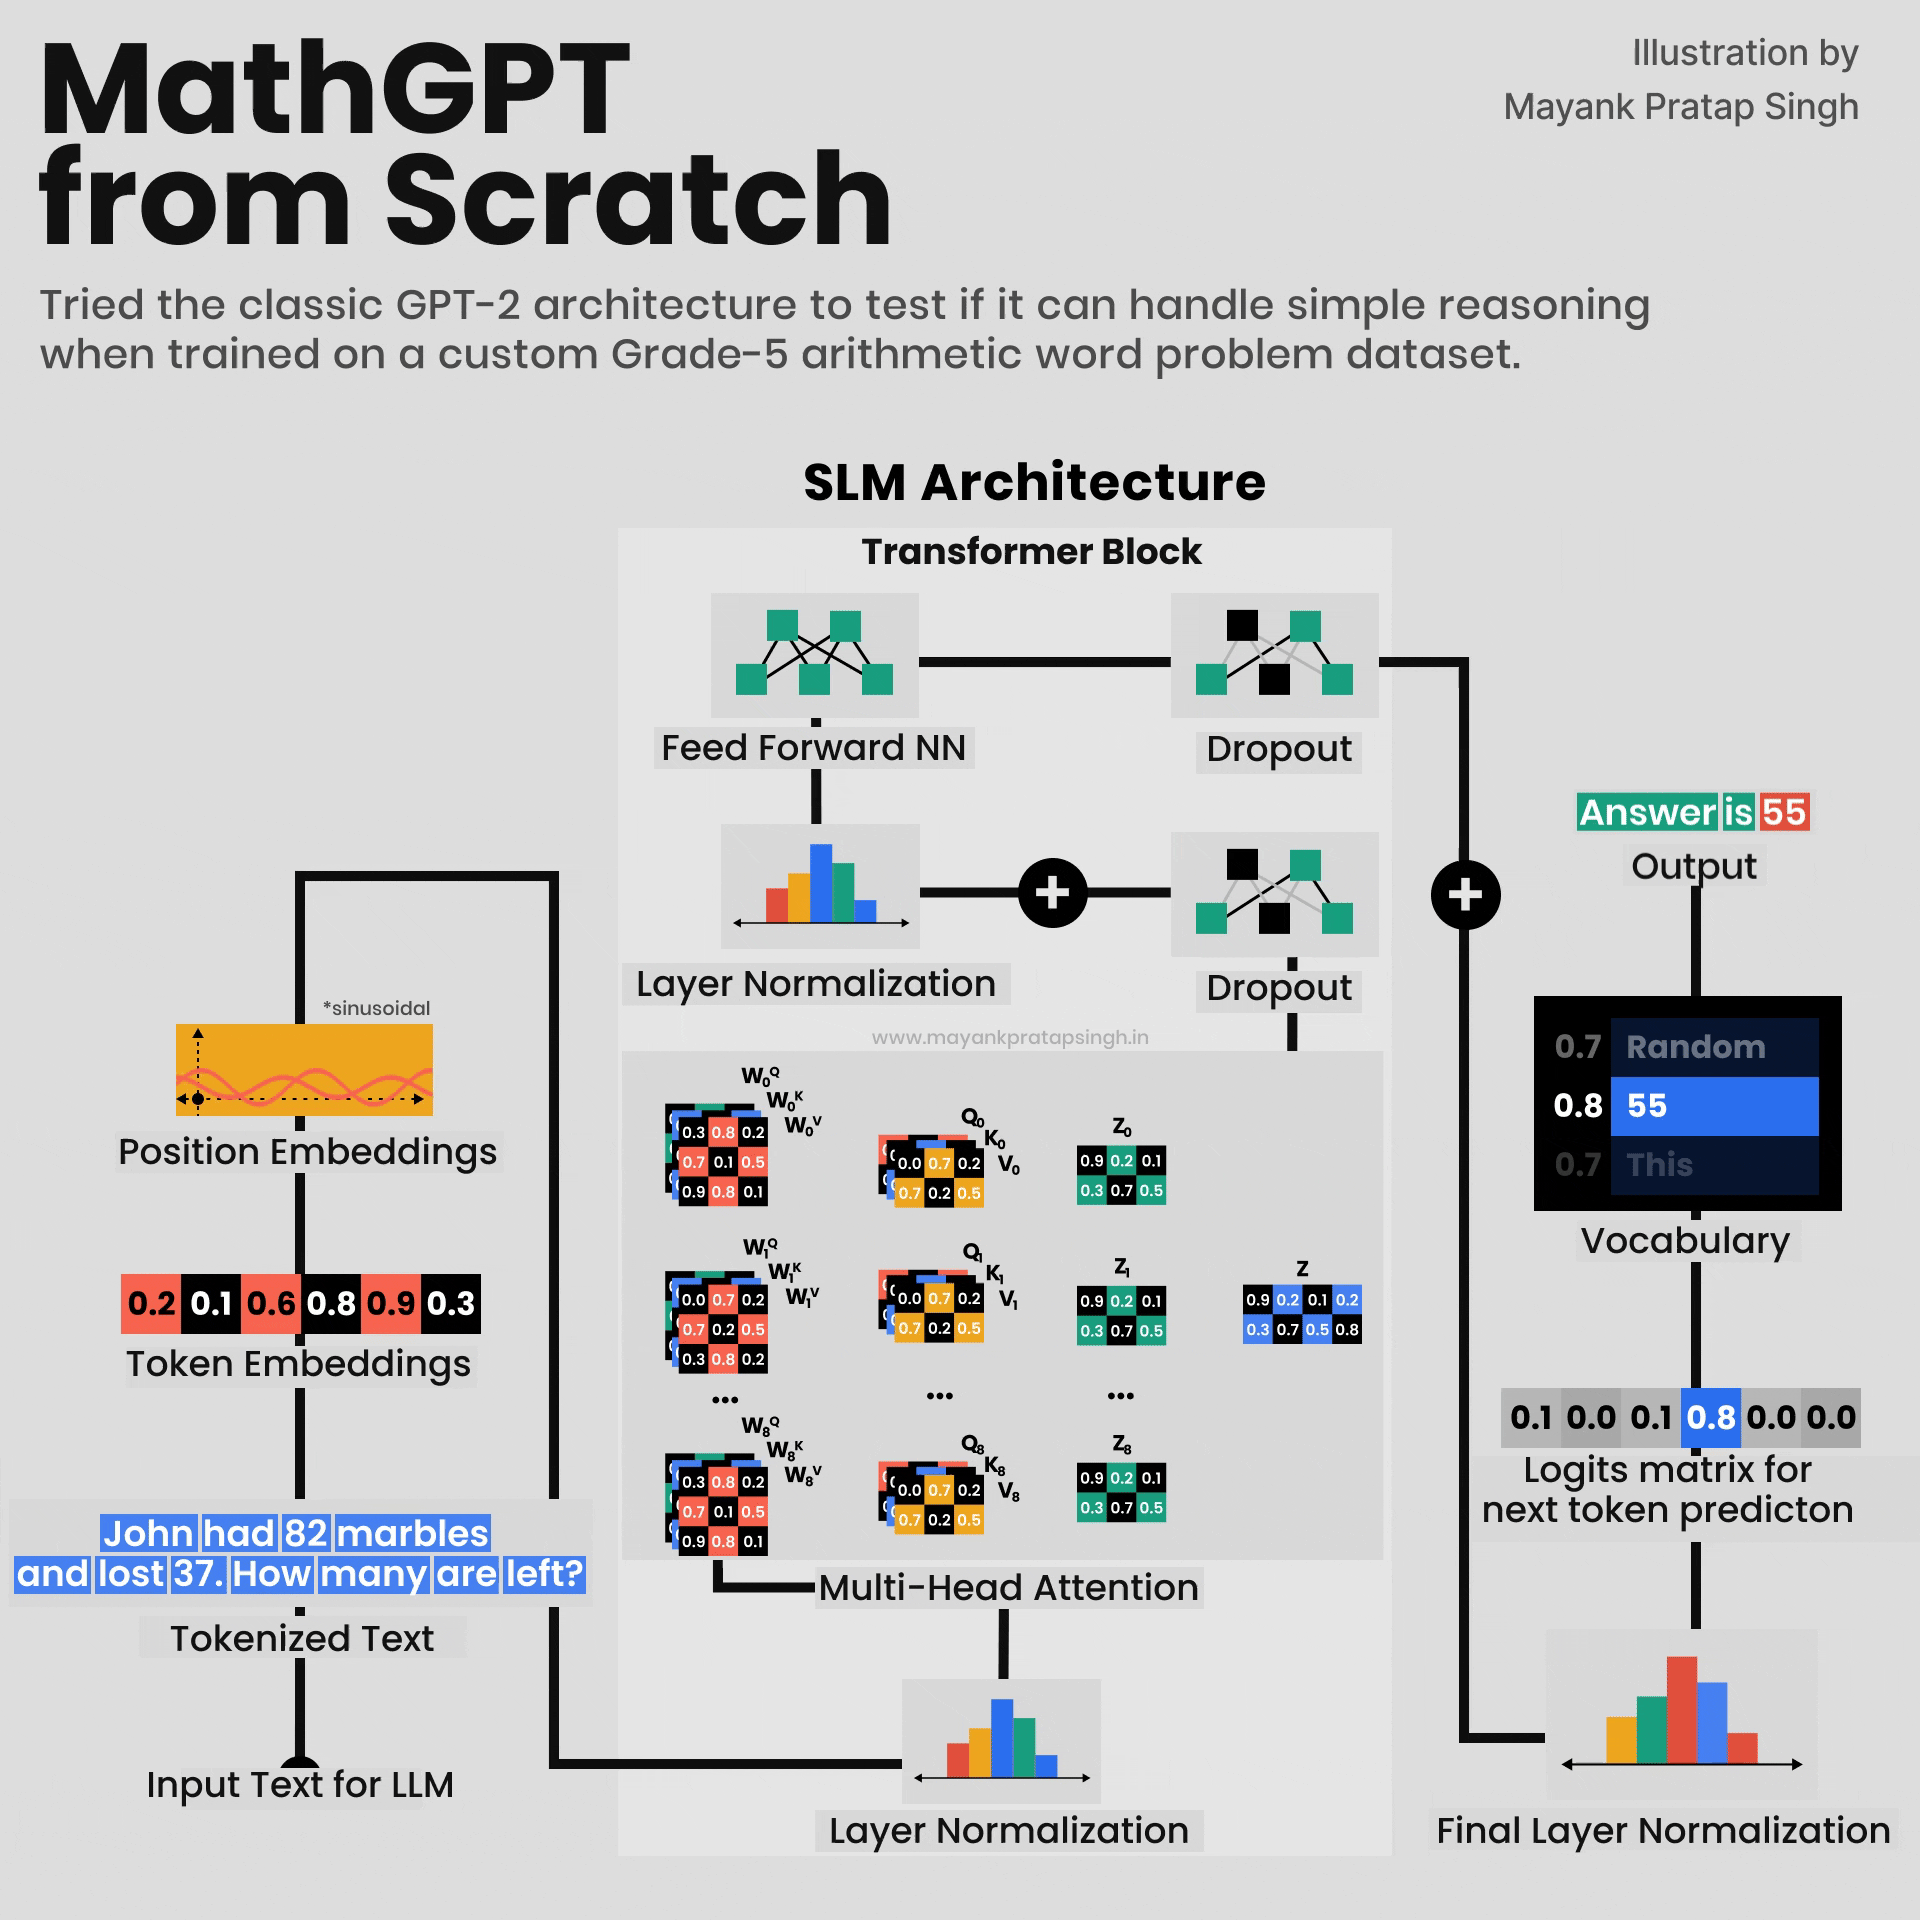

In [ ]:
!pip install tiktoken

# Import Datast

In [ ]:
import tiktoken
import numpy as np
import os
from tqdm import tqdm

# Load your extracted corpus
# with open("/content/drive/MyDrive/Final_SLM_homework/add_sub_multi_dataset.txt", "r", encoding="utf-8") as f:
with open("/content/sub_dataset.txt", "r", encoding="utf-8") as f:
    text = f.read()

# Load GPT-2 tokenizer
enc = tiktoken.get_encoding("gpt2")

# Tokenize
ids = enc.encode_ordinary(text)  # no special tokens
print(f"Total tokens: {len(ids)}")

# Convert to NumPy array
ids = np.array(ids, dtype=np.uint16)  # GPT-2 vocab size < 65536

# Train/Val split
split = int(len(ids) * 0.9)
train_ids = ids[:split]
val_ids = ids[split:]

# Write to bin files using memory mapping
def write_bin(filename, array):
    arr = np.memmap(filename, dtype=np.uint16, mode='w+', shape=(len(array),))
    arr[:] = array[:]
    arr.flush()

write_bin("train.bin", train_ids)
write_bin("validation.bin", val_ids)

print("✅ Done: train.bin and val.bin are ready.")


Total tokens: 1726996
✅ Done: train.bin and val.bin are ready.


## Step 3: Create Input-Output batches for the dataset

In [ ]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


In [ ]:
def save_checkpoint(model, optimizer, epoch, step, save_dir="checkpoints"):
    os.makedirs(save_dir, exist_ok=True)
    checkpoint_path = os.path.join(save_dir, f"model_epoch{epoch}_step{step}.pt")
    torch.save({
        'epoch': epoch,
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")


## Step 4: Define the SLM Model Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx



# Step 4 A

In [ ]:
config = GPTConfig(
    vocab_size=50257,     # use the tokenizer's vocab size
    block_size=128,       # or whatever context size you're training with
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

## Step 5: Define the loss function

In [ ]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

## Step 6: Define SLM Training Configuration Part 1

In [ ]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 60000 #increase from 25000
warmup_steps = 100 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 100 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

## Step 7: Define SLM Training Configuration Part 2

In [ ]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

<ipython-input-10-a9032b47f003>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


## Step 8: Pre-train the SLM

In [ ]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# List of custom steps (iterations) to save model checkpoints
checkpoint_steps = [10000,30000,60000]  # You can adjust this list

# Ensure model is on the correct device
model = model.to(device)

# Training loop
for epoch in tqdm(range(max_iters)):

    # Evaluate and log every eval_iters
    if epoch % eval_iters == 0 and epoch != 0:
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        # Save the best model
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']

            torch.save(model.state_dict(), best_model_params_path)
            print("✅ Saved best model so far")

    # Fetch a training batch
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    # Forward pass with mixed precision
    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    # Optimizer step after accumulating gradients
    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

    scheduler.step()

    # 🧠 Save model checkpoint at custom steps
    if (epoch + 1) in checkpoint_steps:
        checkpoint_path = f"model_checkpoint_epoch{epoch+1}.pt"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict()
        }, checkpoint_path)
        print(f"Saved checkpoint at epoch {epoch+1} → {checkpoint_path}")


  0%|          | 0/60000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 100: train loss 8.7411, val loss 9.1108
The current learning rate: 0.00010
✅ Saved best model so far
Epoch 200: train loss 8.1360, val loss 8.7573
The current learning rate: 0.00010
✅ Saved best model so far
Epoch 300: train loss 7.6757, val loss 8.5397
The current learning rate: 0.00010
✅ Saved best model so far
Epoch 400: train loss 7.2626, val loss 8.4033
The current learning rate: 0.00010
✅ Saved best model so far
Epoch 500: train loss 6.9121, val loss 8.3017
The current learning rate: 0.00010
✅ Saved best model so far
Epoch 600: train loss 6.5872, val loss 8.1488
The current learning rate: 0.00010
✅ Saved best model so far
Epoch 700: train loss 6.2839, val loss 8.0035
The current learning rate: 0.00010
✅ Saved best model so far
Epoch 800: train loss 5.9226, val loss 7.8588
The current learning rate: 0.00010
✅ Saved best model so far
Epoch 900: train loss 5.6876, val loss 7.7551
The current learning rate: 0.00010
✅ Saved best model so far
Epoch 1000: train loss 5.4551, val lo

In [ ]:
# import csv

# # File name for saving
# filename = "loss_logs.csv"

# # Open and write the CSV
# with open(filename, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Epoch', 'Train Loss', 'Validation Loss'])  # Header
#     for i, (train_loss, val_loss) in enumerate(zip(train_loss_list, validation_loss_list), start=1):
#         writer.writerow([i, train_loss, val_loss])

# print(f"Saved to {filename}")

Saved to loss_logs.csv


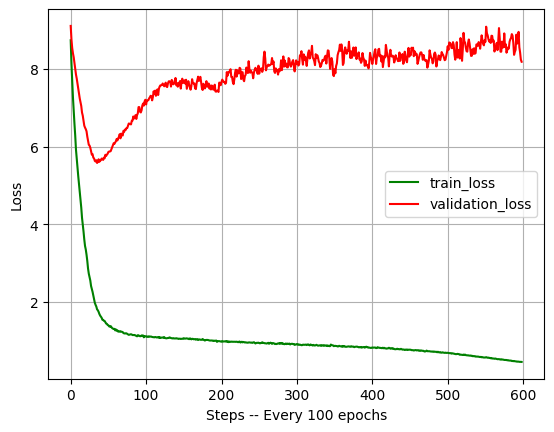

In [ ]:
import matplotlib.pyplot as plt

# No need to use .cpu().detach(); values are already floats

train_loss_list_converted = [float(i) for i in train_loss_list]
validation_loss_list_converted = [float(i) for i in validation_loss_list]

# Plotting
plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps -- Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## Step 9: Plot the SLM Loss Function

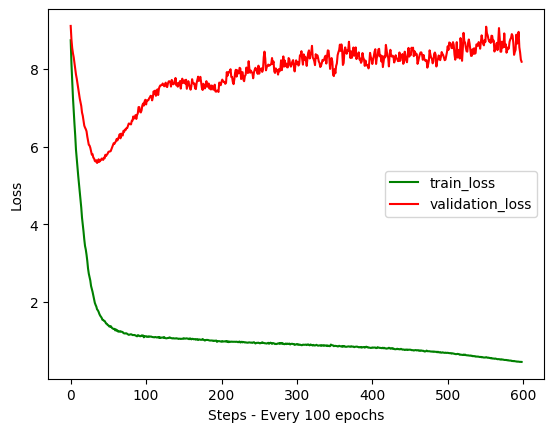

In [ ]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



## Step 10: Run SLM Inference on our trained model

In [ ]:
import tiktoken
# Load GPT-2 tokenizer
enc = tiktoken.get_encoding("gpt2")

In [ ]:
#Load the model
model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "/content/model_checkpoint_epoch60000.pt"
# model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states
checkpoint = torch.load(best_model_params_path, map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])  # ✅ only load model weights

<All keys matched successfully>

#Test 1

In [ ]:
# sentence = "A two-wheeler costs 21214 and three wheeler 48894 rupees. What is the total cost?"
# context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
# y = model.generate(context, 200)
# print(enc.decode(y.squeeze().tolist()))

sentence = "Substract 7594 - 52"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Substract 7594 - 52
A: 7373

Q: Substract 9492 - 61
A: 9429

Q: Substract 9121 - 77
A: 9026

Q: Substract 3629 - 16
A: 3608

Q: Substract 3796 - 12
A: 3864

Q: Substract 8213 - 73
A: 8134

Q: Substract 7865 - 30
A: 7836

Q: Substract 9237 - 30
A: 9246

Q: Substract 2793 - 25
A: 2771

Q: Substract 6774 - 67
A: 6719

Q: Substract 8376 - 56
A: 8335

Q: Substract 1702 - 55
A: 1647

Q: Substract 3796 - 84
A: 3752

Q: Substract 5548 - 60
A: 5489


#Test 2

In [ ]:
# sentence = "Add 111 + 931"
# context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
# y = model.generate(context, 200)
# print(enc.decode(y.squeeze().tolist()))

sentence = "Subtract 20304 - 87"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Subtract 20304 - 8730
A: 11747

Q: Subtract 88589 - 7869
A: 80626

Q: Subtract 59768 - 785
A: 58792

Q: Subtract 15871 - 9254
A: 76405

Q: Subtract 79005 - 6656
A: 72326

Q: Subtract 88376 - 5912
A: 82593

Q: Subtract 27118 - 5988
A: 20443

Q: Subtract 47367 - 8797
A: 38680

Q: Subtract 19375 - 9937
A: 9327

Q: Subtract 50006 - 5397
A: 44035

Q: Subtract 44501 - 880
A: 35629

Q: Subtract 61646 - 9279
A: 52104




# Test 3

In [ ]:
# sentence = "Mutiply 22793 x 7739 ="
# context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
# y = model.generate(context, 200)
# print(enc.decode(y.squeeze().tolist()))


sentence = "A two-wheeler costs 5367 and three wheeler 55690 rupees. Subtract high value from low?
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Object `low` not found.
Subtract 20304 - 8721
A: 11868

Q: Subtract 56768 - 1502
A: 55384

Q: Subtract 36197 - 8921
A: 27291

Q: Subtract 90817 - 4713
A: 85810

Q: Subtract 74250 - 6753
A: 68675

Q: Subtract 23618 - 6297
A: 16019

Q: Subtract 27040 - 2583
A: 24017

Q: Subtract 254 21790 - 3773
A: 22520

Q: Subtract 56599 - 4332
A: 52348

Q: Subtract 51435 - 4584
A: 47649

Q: Subtract 40649 - 2670
A: 37889

Q: Subtract 41691 - 1473
A:


#Test 4

In [ ]:
sentence = "Q: A school student 561 took 8 rupees. What is the amount left?"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Q: A school student 561 took 8 rupees. What is the amount left?
A: 553.

Q: A school student 665 took 9 rupees. What is the amount left?
A: 657.

Q: A school student 912 took 9 rupees. What is the amount left?
A: 904.

Q: A school student 496 took 1 rupees. What is the amount left?
A: 496.

Q: A school student 414 took 1 rupees. What is the amount left?
A: 411.

Q: A school student 336 took 5 rupees. What is the amount left?
A: 430.

Q: A school student 812 took 8 rupees. What is the amount left?
A: 804.

Q: A school student 168 took 1 rupees. What is the amount left?
A: 166.

Q: A school student 926 took 9 rupees. What is the amount


In [ ]:
sentence = "Total cost of a computer 47509. Monitor costs 339 by itself.What is the cost of computer without the monitor?"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Total cost of a computer 47509. Monitor costs 339 by itself.What is the cost of computer without the monitor?
A: 46957

Q: Total cost of a computer 90970. Monitor costs 967 by itself.What is the cost of computer without the monitor?
A: 90094

Q: Total cost of a computer 57784. Monitor costs 556 by itself.What is the cost of computer without the monitor?
A: 57420

Q: Total cost of a computer 45561. Monitor costs 333 by itself.What is the cost of computer without the monitor?
A: 45294

Q: Total cost of a computer 60182. Monitor costs 459 by itself.What is the cost of computer without the monitor?
A: 60030

Q: Total cost of a computer 54356. Monitor costs 908 by itself.What is the cost of computer without the monitor?
A: 53441

Q: Total cost of a computer 70025. Monitor costs 861 by itself.What is the


In [ ]:
sentence = "Substract 51092 - 21"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Substract 51092 - 21
A: 51064

Q: Substract 68183 - 69
A: 68165

Q: Substract 24734 - 55
A: 24780

Q: Substract 44095 - 37
A: 45068

Q: Substract 82549 - 67
A: 82389

Q: Substract 38915 - 42
A: 38 61059

Q: Substract 56747 - 77
A: 56572

Q: Substract 50720 - 72
A: 50867

Q: Substract 54 drive time going to a computer 29870 - 46
A: 29822

Q: Substract 96523 - 46
A: 96366

Q: Substract 82527 - 16
A: 82405

Q: Substract 98815 - 89
A: 98626

Q: Substract 96645 - 61
